<h1>Cas9 Targeted Sequencing Tutorial</h1>

This tutorial is intended as an introduction into the analysis of a Cas9 targeted sequencing experiment with nanopore sequencing. The tutorial will step through and discuss the steps of the workflow starting from raw sequencing data. We will learn how to:

* Align read data to a human reference sequence
* Show the sequencing depth for target regions
* Analyse the proportion of off-target reads

The tutorial makes use of some common bioinformatics including:

* `mini_align` - a simple interface to the [`minimap2`](https://github.com/lh3/minimap2) alignment program.
* [`pyranges`](https://github.com/biocore-ntnu/pyranges) - GenomicRanges and genomic Rle-objects for Python.

Computational requirements for this tutorial include:

- Computer running the **EPI2ME Labs** notebook Server
- At least 16 Gb RAM



⚠️ **Warning:** This notebook has been saved with its outputs for demostration purposed. It is recommeded to select `Edit > Clear all outputs` before using the notebook to analyse your own data.




## Introduction

The tutorial requires a FASTQ format sequence file and a BED file of target coordinates as input, along with pointers to download locations for the reference genome to be used.

The tutorial aids with the quantification of the non-target depletion and provides information on mapping characteristics that highlight the protocol performance. The figures plotted include depth-of-coverage over the target regions and strand bias over these regions. The location and peaks of coverage and local biases in strandedness may be used to assess the performance of guide-RNA sequences and may highlight guide RNAs that are not performing. A review of likely off-target regions over-represented within the sequence collection may inform of strategies to refine guide-RNA design.


## Data preparation

The workflow below accepts a single or multiple `.fastq` files containing single molecule reads. In addition a reference `.fasta` file is required and a `.bed` file describing the target regions.

Before anything else we will create and set a working directory:

In [4]:
from epi2melabs import ping
pinger = ping.Pingu()
pinger.send_notebook_ping('start', 'targeted_sequencing')

# create a work directory and move into it
tutorial_name = 'cas9_tutorial'
working_dir = '/epi2melabs/{}/'.format(tutorial_name)
!rm -rf "$working_dir"
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/cas9_tutorial


### Sample Data

To use this tutorial with sample data we can download the files using the `linux` command `wget`. We will download three files:

1. A .fastq file containing our sequencing data
2. The human reference genome
3. A .bed file describing the target regions of the genome


First to download the sequencing data we run (again press Play to execute the code):

In [ ]:
bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
domain = "s3-eu-west-1.amazonaws.com"
site = "https://{}.{}".format(bucket, domain)

# download the data
!wget "$site/cas9_tutorial/sample_cas9.tar.gz"
# the data is in a compressed archive so let's decompress it
!tar -xzvf sample_cas9.tar.gz

The data downloaded is laid-out in the form as written by MinKNOW on a sequencing device, only reads passing the quality score filter applied by MinKNOW has been included (again click the cell and press Play):

In [6]:
!tree sample_cas9

sample_cas9
└── fastq_pass
    ├── FAK76554_9b52beb8b4f9ec458eb28c28b35822acaff84952_0.fastq
    └── FAK76554_9b52beb8b4f9ec458eb28c28b35822acaff84952_1.fastq

1 directory, 2 files


For our analysis we will also need the human genome reference (*note that this download is quite large, it includes both the reference sequence and indexes required for analysis*):

In [ ]:
!wget "$site/grch38.tar.gz"
!tar -xzvf grch38.tar.gz
# mini_align will not like this file being present
!rm grch38/grch38.fasta.gz.fai

The reference contained within the above download is that which can also be obtained [here](http://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000/001/405/GCA_000001405.15_GRCh38/seqs_for_alignment_pipelines.ucsc_ids/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna.gz), the reasons for using this file are presented in Heng Li's [blog post](https://lh3.github.io/2017/11/13/which-human-reference-genome-to-use).

Finally we will need a `BED` file describing the target regions of the genome.

In [ ]:
!wget -O targets.bed "$site/cas9_tutorial/targets.bed"

### Using your own data

If you wish to analyse your own data rather than the sample data, you can edit the value `.fastq input` variable below. To find the correct full path of a directory you can navigate to it in
the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

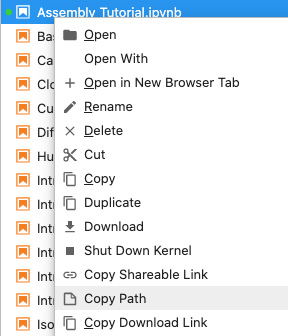

The location shared with the EPI2ME labs server from your computer will show as `/epi2melabs`, for example a file located at `/data/my_gridion_run/fastq_pass` on your computer will appear as `/epi2melabs/my_gridion_run/fastq_pass` when it is the `/data` folder that is shared.


### Data entry

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the filepaths as input to the notebook.



> **If you want simply to plot all the graphs in this tutorial for your dataset, rather than working through the tutorial, select `Run Selected Cell and All Below` from the `Run` menu above after executing the cell below.**

In [4]:
import os
import pandas as pd

import aplanat
import aplanat.graphics
import aplanat.report
from epi2melabs.notebook import InputForm, InputSpec

import ipywidgets as widgets

input_file = None
reference_genome = None
output_folder = None
region_bed = None
target_names = None
exec_summary = None
report = None

def process_form(inputs):
    global input_file
    global output_folder
    global reference_genome
    global region_bed
    global target_names
    global exec_summary
    global report
    
    # run a command to concatenate all the files together
    print("Making output folder...")
    output_folder = inputs.output_folder
    !mkdir -p "$output_folder"
    reference_genome = inputs.reference_genome
    !test -f "$reference_genome" || echo "WARNING: Reference file does not exist"
    input_file = os.path.join(inputs.output_folder, "input.fastq")
    print("Compiling fastq data...")
    !rationalize_fastq -i "$inputs.input_data" -o "$input_file"

    print("Reading bed file...")
    region_bed = pd.read_csv(
        inputs.bed_file, sep='\t', header=None,
        # https://genome.ucsc.edu/FAQ/FAQformat.html#format1
        names=[
            'chrom', 'start', 'end',  #required
            'tname', 'score', 'strand', 'thickStart', 'thickEnd',
            'itemRgb', 'blockCount', 'blockSizes', 'blockStarts'])

    region_bed['region'] = [
        '{}:{}-{}'.format(x['chrom'], x.start, x.end)
        for _, x in region_bed.iterrows()]
    target_names = region_bed['tname'].to_list()
    
    print("Initializing report...")
    exec_summary = aplanat.graphics.InfoGraphItems()
    report = aplanat.report.HTMLReport(
        "Cas9 Targeted Sequencing", "EPI2ME Labs Summary")
    report.markdown("## Excutive summary", key='exec-head')
    report.plot(None, key='exec-plot')  # placeholder
    print("Done")
        
inputs = InputForm(
    InputSpec('input_data', '.fastq input', 'sample_cas9/fastq_pass'),
    InputSpec('output_folder', 'Output folder', 'analysis'),
    InputSpec('reference_genome', 'Reference Genome', 'grch38/grch38.fasta.gz'),
    InputSpec('bed_file', 'Targets .bed file', 'targets.bed'),
)
inputs.add_process_button(process_form)
inputs.display()

## Alignment of reads

Our first task in analysing our data is to align the sequence reads to the reference sequence. We do this with the `mini_align` program from the [`pomoxis`](https://github.com/nanoporetech/pomoxis) package. This is preinstalled in the **EPI2ME Labs** notebook server. Note that this command may take a while to run depending on the number of reads in your datasets. With the sample data (8000 reads) and using 4 compute threads (`-t 4` in the code), the alignments will take around 5 minutes.


In [ ]:
print(reference_genome)
print(output_folder)
print(input_file)
!run mini_align \
    -r "$reference_genome" -i "$input_file" \
    -p "$output_folder/alignments" \
    -t 4 -m
# for brevity the results of the above for the sample data can also be downloaded:
#!wget -O "$output_folder/alignments.bam" "$site/cas9_tutorial/alignments.bam"
#!wget -O "$output_folder/alignments.bam.bai" "$site/cas9_tutorial/alignments.bam.bai"

While we are here we will calculate also a table summarising the alignment data, again using a program from `pomoxis`:

In [10]:
# Calculating alignment summaries (click play)
!stats_from_bam "$output_folder/alignments.bam" \
    > "$output_folder/alignments.stats"

import pandas as pd
aln_summary = pd.read_csv(
    '{}/alignments.stats'.format(output_folder),
    delimiter='\t')
# Add entries to our summary and report
bases = aln_summary['read_length'].sum()
exec_summary.append(
    'Throughput', bases, 'calculator', 'B')
report.markdown("""
## Read Summary

The total throughput of the experiment was: {}""".format(bases),
key='align_header')

Mapped/Unmapped/Short/Masked: 7827/0/0/0


The summary file gives useful information on the alignment of each read to the reference sequence, including: chromosome, start and end coordinates, and the accuracy of the read with respect to the reference. We can plot a histogram of the latter quantity:

In [11]:
# Plotting read accuracy distributions (click play)

import numpy as np
import aplanat
from aplanat import annot, lines, util

x_grid, pdf = util.kernel_density_estimate(aln_summary.acc)
mode_acc = x_grid[np.argmax(pdf)]
mean_acc = aln_summary.acc.mean()

# create a figure
plot = lines.line([x_grid], [pdf], xlim=(75,100))
for x, name in ((mode_acc, 'Mode'), (mean_acc, 'Mean')):
    plot = annot.marker_vline(plot, x, label='{}: {:.1f}'.format(name, x))
# add axis labels
plot.xaxis.axis_label = 'Read Accuracy'
plot.yaxis.axis_label = 'Read density'
aplanat.show(plot)
report.plot(plot, key='accuracy plot')

The statistics file has many other columns which are interesting to explore:

In [ ]:
aln_summary.info()

## On Target Depth

In this section we will examine the depth of sequencing for each of the target regions, and count reads aligning to other genomic locations.

For this purpose and throughout the rest of this tutorial we will use the [`Pyranges`](https://github.com/biocore-ntnu/pyranges) library.

### Simple Overlaps

As a first look at the data lets tabulate the number of reads overlapping each target. All overlaps are counted here, including partial overlaps.

In [13]:
import pyranges as pr

targets = region_bed[['chrom','start','end','tname']].rename(
    columns={'chrom':'Chromosome','start':'Start','end':'End'}
)
targets = pr.PyRanges(targets)

reads = aln_summary.rename(
    columns = {'ref':'Chromosome','rstart':'Start','rend':'End', 'direction':'Strand'}
)
reads = pr.PyRanges(reads)
ovl_summary = targets.count_overlaps(reads)
ovl_summary.df

,Chromosome,Start,End,tname,NumberOverlaps
0,chr1,155180400,155200000,MUC1,28
1,chr4,3072000,3078000,HTT,84
2,chr6,170556800,170566300,SCA17,76
3,chr9,27571600,27577500,C9orf72,39
4,chr11,2158100,2167500,INS,55
5,chr12,111596700,111603400,SCA2,231
6,chr14,92067100,92075400,SCA3,95
7,chr19,13204400,13211100,SCA6,62
8,chr22,45791500,45799400,SCA10,124
9,chrX,147910700,147933700,FMR1,70


The table above summaries the number of times a read overlaps one of the targets. We can also think about the inverse problem, how many times the targets intersect the reads; this allows us to calculate approximately numbers of on-target and non-target bases. Non-target bases are defined simply as any base not belonging to a target region; we will break down this category further later in the tutorial.

In [14]:
# Finding on-target reads (click play)

# get on/off target reads
ovl = reads.count_overlaps(targets)
on_target = ovl[ovl.NumberOverlaps > 0]
non_target = ovl[ovl.NumberOverlaps == 0]
def summarize(df):
    count = len(df)
    bases = sum(df.End) - sum(df.Start)
    ave_len = int(df.read_length.mean())
    return count, bases // 1000, ave_len
on_stats = summarize(on_target)
non_stats = summarize(non_target)
all_stats = summarize(ovl)

info = pd.DataFrame([
        on_stats, non_stats, all_stats],
    columns=['Reads', 'Bases / k', 'Mean Read Length'],
    index=['On-target', 'Non-target', 'All'],
    ).transpose()
display(info)

# update our summaries
exec_summary.extend([
    ('On-target', 1000*info['On-target']['Bases / k'], 'crosshairs', 'B'),
    ('Non-target', 1000*info['Non-target']['Bases / k'], 'dot-circle', 'B'),
    ('Reads on target', 100 * info['On-target']['Reads'] / info['All']['Reads'], 'signal', '%')])
report.markdown("""
## Target Summary

Reads were aligned the the reference sequence and their alignment assessed for
overlap to target regions. The table below counts reads which align (on-target)
and do not align (non-target) to a a target region. Later sections of this report
further divide the latter category into background and enriched off-target regions.
""", key='target_summary_header')
report.table(info, index=True, key='on-non-summary', height=100)

,On-target,Non-target,All
Reads,864,6963,7827
Bases / k,4785,64253,69038
Mean Read Length,5501,9348,8924


### Genome tiles

In order to calculate quickly and efficiently more detailed statistics (and create informative plots), we will use a genome tiling technique. We will split the reference genome into uniformly sized tiles; for each reference tile we can calculate the overlapping reads. We create a tile for both the `+` and the `-` DNA strand. For the reference we construct the tiles using the `pysam` library to read the `reference_genome` file:

In [15]:
import pysam
tile_size = 100

ref = pysam.FastaFile(inputs.reference_genome)
ref_tiles = pr.concat([
    pr.PyRanges(
        chromosomes=ref.references,
        starts=[0] * ref.nreferences,
        ends=ref.lengths,
        strands=[strand] * ref.nreferences).tile(tile_size=tile_size)
    for strand in '+-'])

We will also define a small helper function to annotate genomic regions with additional information:

In [16]:
# Defining a `set_column` function for annotating regions
def set_column(pyr, chrom, loc, column, value, strand=None):
    """Sets a column of a `PyRange` to a specified value.
    
    :param pyr: a `PyRange`.
    :param chrom: a chromosome.
    :param loc: a `Slice` (start, stop).
    :param column: column name.
    :param value: value to set the column.
    """
    from pyranges.subset import find_overlaps

    keys = [chrom]
    if pyr.stranded:
        keys = [(chrom, x) for x in '+-']

    for key in keys:
        dfs = {key: pyr.dfs[key]}
        max_end = list(dfs.values())[0].End.max()
    
        start = loc.start or 0
        stop = loc.stop or max(max_end, start)
        for k, df in dfs.items():
            idx = find_overlaps(df, start, stop)
            df.loc[idx, column] = value

To proceed we will first use the function defined above to annotate our genome tiles and our reads with their target:

In [17]:
# Label reference genome tiles, and the reads
ref_tiles.tname = 'Non-Target'
reads.tname = 'Non-Target'
for chrom, df in targets:
    for _, t in df.iterrows():
        print("Labelling {}".format(t.tname), end="...")
        print("ref tiles", end='...')
        set_column(
            ref_tiles, t.Chromosome, slice(t.Start, t.End),
            'tname', t.tname)
        print('read tiles', end='...')
        set_column(
            reads, t.Chromosome, slice(t.Start, t.End),
            'tname', t.tname)
        print()
# count overlaps of read tiles to ref_tiles (similar to before)
print('Calculating read hits')
hits = ref_tiles.count_overlaps(reads, strandedness='same')

Labelling MUC1...ref tiles...read tiles...
Labelling HTT...ref tiles...read tiles...
Labelling SCA17...ref tiles...read tiles...
Labelling C9orf72...ref tiles...read tiles...
Labelling INS...ref tiles...read tiles...
Labelling SCA2...ref tiles...read tiles...
Labelling SCA3...ref tiles...read tiles...
Labelling SCA6...ref tiles...read tiles...
Labelling SCA10...ref tiles...read tiles...
Labelling FMR1...ref tiles...read tiles...
Calculating read hits


Having prepared these tables we can now query them in various ways. Let's summarise the information we have for each target:

In [18]:
# Summarizing targets (click play)
def target_info(target_name, targets, hits, reads):
    print('Getting statistics for {}.'.format(target_name))
    info = targets[targets.tname == target_name].df
    # Find intersecting hits
    t_hits = hits.intersect(pr.PyRanges(info)).df
    t_reads = reads.df[reads.df['tname'] == target_name]

    info['tsize'] = info.End - info.Start
    # use the tiles to calculate bases on target as parts of reads
    # may not overlap
    info['kbases'] = tile_size * t_hits['NumberOverlaps'].sum() / 1000
    info['median_coverage'] = \
        t_hits.groupby('Start')['NumberOverlaps'].sum().median().astype(int)
    if len(t_reads) > 0:
        info['nreads'] = t_reads['name'].unique().size
        info['mean_read_length'] = t_reads['read_length'].mean()
        info['mean_accuracy'] = t_reads['acc'].mean()
        fwd, rev = (len(t_reads[t_reads['Strand'] == x]) for x in '+-')
        info['strand_bias'] = (fwd - rev) / (fwd + rev) 
    else:
        info['nreads'] = 0
        info['mean_read_length'] = np.nan
        info['mean_accuracy'] = np.nan
        info['strand_bias'] = 0   
    return info

target_summary = list()
for target in target_names:
    target_summary.append(target_info(
        target, targets, hits, reads
    ))
target_summary = pd.concat(target_summary).rename(columns={
    'Chromosome':'chrom', 'Start':'start', 'End':'end'})
pd.options.display.float_format = '{:,.2f}'.format
display(target_summary)
exec_summary.append(
    "Target coverage", target_summary['median_coverage'].median(), "align-justify", "X")
report.markdown(
    "Summary of reads by target. See notebook for details of column.",
    "read-targets")
report.table(
    target_summary, index=False, key='target-reads',
    height=min(600, 25*(len(target_summary)+1)))

Getting statistics for MUC1.
Getting statistics for HTT.
Getting statistics for SCA17.
Getting statistics for C9orf72.
Getting statistics for INS.
Getting statistics for SCA2.
Getting statistics for SCA3.
Getting statistics for SCA6.
Getting statistics for SCA10.
Getting statistics for FMR1.


,chrom,start,end,tname,tsize,kbases,median_coverage,nreads,mean_read_length,mean_accuracy,strand_bias
0,chr1,155180400,155200000,MUC1,19600,269.70,18,28,"10,618.14",87.95,-0.14
1,chr4,3072000,3078000,HTT,6000,363.70,74,84,"4,432.71",91.97,-0.12
2,chr6,170556800,170566300,SCA17,9500,447.10,60,76,"6,415.24",92.89,0.08
3,chr9,27571600,27577500,C9orf72,5900,80.10,21,39,"2,201.95",91.63,-0.38
4,chr11,2158100,2167500,INS,9400,246.70,36,55,"5,142.13",89.65,0.27
5,chr12,111596700,111603400,SCA2,6700,564.70,103,231,"2,529.79",92.37,0.06
6,chr14,92067100,92075400,SCA3,8300,385.20,72,95,"5,290.09",93.27,-0.07
7,chr19,13204400,13211100,SCA6,6700,255.30,53,62,"6,689.50",90.29,-0.35
8,chr22,45791500,45799400,SCA10,7900,627.00,109,124,"5,019.86",93.36,-0.06
9,chrX,147910700,147933700,FMR1,23000,808.50,37,70,"15,762.01",92.85,0.11


The table details:

* `tname` --- the target name.
* `tsize` --- the length of the target (in bases).
* `kbases` --- approximate number of bases in reads overlapping target.
* `median_coverage` --- average read depth across target.
* `nreads` --- number of reads aligning.
* `mean_read_length` --- average read length of reads aligning.
* `mean_accuracy` --- average base accuracy of reads aligning.
* `strand_bias` --- proportional difference of reads aligning to each strand. A value or +1 or -1 indicates complete bias to the foward or reverse strand respectively.

Using the tiling statistics we can make coverage plots for all regions.

In [19]:
# Creating coverage plots (click play)
from bokeh.layouts import gridplot
from bokeh.models import Legend

ncols = 4
plots = list()
for i, target in enumerate(target_names):
    info = targets[targets.tname == target].df
    reg = region_bed[region_bed.tname == target].reset_index()
    t = hits.intersect(pr.PyRanges(info)).df
    fwd, rev = (t[t['Strand'] == x] for x in '+-')
    names = [None, None]
    extra_width = 0 if i != ncols - 1 else 80

    p = lines.line(
        [fwd.Start, rev.Start],
        [fwd.NumberOverlaps, rev.NumberOverlaps],
        colors=['sienna', 'forestgreen'], names=names,
        height=200, width=300 + extra_width,
        title='{} - {}:{}-{}'.format(
            reg['tname'][0], reg['chrom'][0],
            reg['start'][0], reg['end'][0]))
    p.xaxis.formatter.use_scientific = False
    p.xaxis.major_label_orientation = 3.14/6
    if i == ncols - 1:
        legend = Legend(
            items=[("+", p.renderers[0:1]), ("-", p.renderers[1:])])
        p.add_layout(legend, 'right')
    plots.append(p)

plot = gridplot(plots, ncols=ncols)
aplanat.show(plot)

report.markdown(
    "Target coverage by strand. Note that the position co-ordinate is "
    "discretized by {} bases.".format(tile_size),
    "target-cover-plots")
report.plot(plot)

## Examining Non-Target Sequencing

An important consideration for the Cas9 targeted sequencing protocol is the throughput of sequencing not overlapping the target regions, what we have called "non-target" in the sections above. These effects can be broken down further into three types:

1.   **Target proximal** --- sequencing occurring around the target region.
2.   **Off-target** --- enrichment of loci other than those intended, identified as high coverage regions which are not target regions.
3.   **Background** --- non-specific sequencing, identified as low coverage sequencing throughout the genome.

We will examine these effects in this section. In order to do this we will first identify the background level of sequencing. After this we can find regions which are not target regions but which have an abnormally high level of overlapping reads.

### Calculating the background

In order to calculate the background sequencing effect we will first calculate collectively the background and off-target effects. By using the overlaps of reads to the genome tiles calculated previously and subtracting the target regions and proximal regions we obtain the desired result:

In [20]:
# Defining proximal regions (click play)

def create_proximal(source, pad=1000):
    """Create `PyRanges` which flank a source `PyRanges`.

    :param source: ranges for which to create flanks.
    :param pad: length of flanking regions to create.
    """
    lo = source.df.copy()
    lo['End'] = lo['Start']
    lo['Start'] = lo['Start'] - pad
    lo.loc[lo['Start'] < 0, 'Start'] = 0
    hi = source.df.copy()
    hi['Start'] = hi['End']
    hi['End'] = hi['Start'] + pad
    return pr.PyRanges(pd.concat([lo, hi]))

proximal = create_proximal(targets, int(0.5*aln_summary['read_length'].mean()))

# background/off-target is anything not target or proximal
print('Calculating non-target...')
non_hits = pr.PyRanges(hits.df[hits.df['NumberOverlaps'] > 0]) \
    .subtract(pr.concat([targets, proximal])).df
# summarise targets
print('Calculating target...')
target_hits = hits.overlap(targets).df
target_hits.tname = 'On Target'
# and proximal
print('Calculating proximal...')
proximal_hits = hits.overlap(proximal).df
proximal_hits.tname = 'Proximal'

Calculating non-target...
Calculating target...
Calculating proximal...


Naturally determining the boundary between "off-target" and "background" using
the coverage data is a heuristic. To get a qualitative feel for this distintiction we can plot a histogram of the number of genome tiles with defined coverage. For example the plot may hint at some non-target regions with unusally high coverage; often simply large bars at a coverage of 1 and 2 will be observed before a rapid fall off.

In [21]:
# Plotting tile coverage histogram (click play)
from aplanat import hist

# create a histogram of non-target coverage
# for reference, calculate the mean coverage for all target regions
mean_target_coverage = target_summary['median_coverage'].mean()

# create a figure
plot = hist.histogram(
    [non_hits['NumberOverlaps']], binwidth=1, xlim=(0, mean_target_coverage + 5),
    title="Non-target Coverage")
annot.marker_vline(plot,
    mean_target_coverage,
    label='{}: {:.0f}'.format('on-target', mean_target_coverage))
# add axis labels
plot.xaxis.axis_label = 'Background Coverage (stranded)'
plot.yaxis.axis_label = '# tiles'
aplanat.show(plot)

report.markdown("""
## Examining off-target enrichment

This section illustrates potential undesired enrichment. The coverage of
non-target regions is depicted in the histogram below.""")
report.plot(plot, key="off-target-comp-plot")


The widget below can also be used to choose where the boundary should lie in according to the coverage or these regions:

In [5]:
def summary(df):
    kbases = tile_size * df['NumberOverlaps'].sum() // 1000
    mean_cover = df['NumberOverlaps'].mean()
    return pd.Series((kbases, mean_cover), index=['kbases', 'mean_coverage'])

def process_form(inputs):
    non_hits.loc[non_hits['NumberOverlaps'] > inputs.strand_coverage, 'tname'] = 'Off Target'
    non_hits.loc[non_hits['NumberOverlaps'] <= inputs.strand_coverage, 'tname'] = 'Background'
    res = pd.concat([non_hits, target_hits, proximal_hits])
    res = res.groupby('tname').apply(summary).reset_index(drop=False)
    res.rename(columns={0:'kbases', 'tname':'class'}, inplace=True)
    res['kbases'] = res['kbases'].astype(int)
    report.markdown(
        "Using a (per-strand) coverage filter of {}, the following "
        "categorizations were made:".format(int(inputs.strand_coverage)),
        key="on-off-prox-back-head")
    report.table(res, index=False, key="on-off-prox-back", height=125)
    # first time we run, update widget max
    counts = non_hits['NumberOverlaps'].value_counts()
    inputs.widgets['strand_coverage'].children[0].max = counts.index.max()
    display(res)

class_coverage = InputForm(
    InputSpec('strand_coverage', 'Per-strand coverage', (0, 40, 1)))
class_coverage.add_process_button(process_form)
class_coverage.display()

### Listing off-target regions

Finally to summarise the off-target regions, which could be analysed further, we can merge our genome tiles back into contiguous regions:

In [22]:
# Listing off-target regions (click play)
pinger.send_notebook_ping('stop', 'targeted_sequencing')
off_targets = pr.PyRanges(
    non_hits.loc[non_hits['tname'] == 'Off Target']
).merge().df
report.markdown(
    "The following off-target enrichment was identified:",
    key="off-target-table-head")
report.table(
    off_targets, index=False, key="off-target-table",
    height=min(600, 25*(len(off_targets)+1)))
if len(off_targets) == 0:
    print("No off-target regions found, try adjusting the coverage setting above.")
else:
    display(off_targets)

,Chromosome,Start,End,Strand
0,chr1,16764400,16766500,+


Off-target regions can arise from Cas9 cuts of the source DNA due to probes with low specificity.

## Headline numbers

As a final summary of the experiment the infographic below displays a small set of headline numbers captured through the course of the analysis. Recall that non-target refers to both non-specific background sequencing and unintended enrichment of regions other than the target regions.

In [23]:
# Creating an executive summary (click play)
import aplanat.graphics
exec_plot = aplanat.graphics.infographic(exec_summary.values(), ncols=3)
report.plot(exec_plot, key='exec-plot')
aplanat.show(exec_plot)

Use the form below to export to file the executive summary and target summary data table, and to write a standalone HTML document. The dataset name will be added as an additional column to both files.

In [6]:
def process_form(outputs):
    # note, this makes use of global `inputs` variable
    export_exec = pd.DataFrame.from_dict(
        dict([
            (x[0].replace(" ", "_").lower() + "_" + x[3], [x[1]])
            for x in exec_summary.values()]))
    export_exec.insert(0, 'dataset', outputs.dataset_name)
    fname = os.path.join(inputs.output_folder, 'executive_summary.txt')
    export_exec.to_csv(index=False, sep='\t')
    print("Executive summary written to {}.".format(fname))

    export_summary = target_summary.copy()
    export_summary.insert(0, 'dataset', outputs.dataset_name)
    fname = os.path.join(inputs.output_folder, 'target_summary.txt')
    export_summary.to_csv(fname, index=False, sep='\t')
    print("Target summary written to {}.".format(fname))

    fname = os.path.join(inputs.output_folder, "report.html")
    report.write(fname)
    print("HTML report written to {}.".format(fname))

output_form = InputForm(
    InputSpec('dataset_name', 'Dataset name', 'my_dataset'))
output_form.add_process_button(process_form)
output_form.display()

## Summary

This tutorial has stepped through basic processing of a Cas9 targeted experiment. We have examined the coverage of several target regions and examined the rates of proximal, off-target, and background sequencing effects.
